# Survival Analysis
__Event__ is the experience of interest such as survive/death or stay/resign  
__Survival time__ is the duration until the event of interest occurs i.e. duration until an employee quits

Censored observations happen in time-to-event data if the event has not been recorded for some individuals  
This can be due to two main reasons:
* Event has not yet occurred (i.e. survival time is unknown/misleading for those who are not resigned yet)
* Missing data (i.e. dropout) or losing contact

There are three types of censorship:
* Left-Censored: Survival duration is less than the observed duration
* Right-Censored: Survival duration is greater than the observed duration
* Interval-Censored: Survival duration can’t exactly be defined

The most common type is right-censored and it is usually taken care of by survival analysis  
However, the other two might indicate a problem in the data and might require further investigation.

__Survival Function__  
T is when the event occurs and t is any point of time during the observation, survival S(t) is the probability of T greater than t. In other words, survival function is the probability of an individual will survive after time t.

__Hazard Function__  
Hazard function or hazard rate, h(t), is the probability of an individual who has survived until time t and experiencing the event of interest at exactly at time t. Hazard function and survival function can be derived from each other by using the following formula.


__Reference:__ https://towardsdatascience.com/hands-on-survival-analysis-with-python-270fa1e6fb41  
__Reference:__ https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html

### Requirements

In [203]:
#!conda install -c sebp scikit-survival
#!pip install lifelines

In [204]:
from sksurv.datasets import load_veterans_lung_cancer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importing data: features & event
# event is an array that contains a boolean value along with time to event
# True indicates the event has happend and false indicates the event has not happend
# Data Location: https://github.com/srees1988/predict-churn-py
main = pd.read_csv('customer_churn_data.csv')

# reanming the DataFrame columns
main.rename(columns = {'tenure':'time', 
                       'Churn':'event_occurred'}, 
            inplace = True)

main['event_occurred'] = main['event_occurred'].map({'No':0, 'Yes':1})

main.loc[main.TotalCharges == ' ','TotalCharges'] = '0'
main['TotalCharges'] = [float(i) for i in main.TotalCharges]

In [205]:
main.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,time,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,event_occurred
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


### Data Exploration - Data Shape

In [207]:
print('Number of rows/observations:',main.shape[0])
print('Number of columns:',main.shape[1])

event_ratio = round(main[main.event_occurred == 0].shape[0] / main.shape[0],2)
print('Event Ratio: {} % Occurrance'.format(event_ratio))

Number of rows/observations: 7043
Number of columns: 21
Event Ratio: 0.73 % Occurrance


### Data Exploration - Features

In [208]:
def plot_config(title, axis, y_title, x_title):
    
    # Main Title
    #figure.suptitle('Categorical Plots')

    # Labels
    axis.set_title(title, fontsize=20)
    axis.set_xlabel(x_title, fontsize=15)
    axis.set_ylabel(y_title, fontsize=15)
    
    # Graph Spins
    # Plot 1: Config
    axis.spines['right'].set_visible(False)
    axis.spines['top'].set_visible(False)
    
    # Tickmark Sizes
    axis.tick_params(axis='both', which='major', labelsize=15)
    
def rods_survival_plot(event_duration, event_occurred, axis, label = None):# Plot: Config

    # Initiate and fit
    kmf = KaplanMeierFitter()
    kmf.fit(durations=event_duration, event_observed=event_occurred, label=label)
    
    # KM Plot
    kmf.survival_function_.plot(ax=axis, color='black', linestyle = '--')

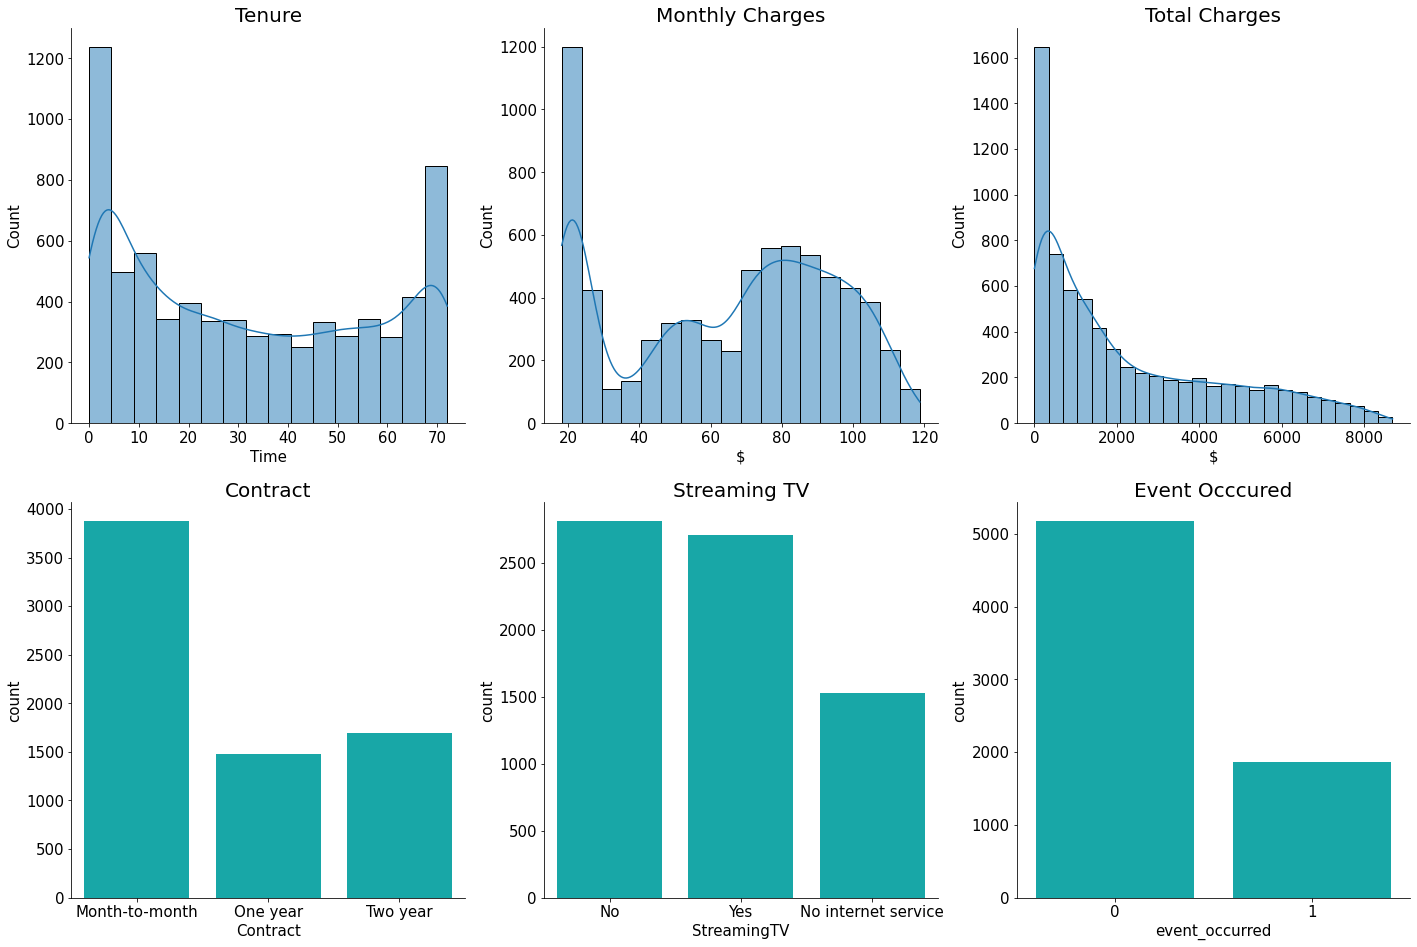

In [209]:
# Creating Figure
figure, axis = plt.subplots(2,3,figsize = (24,16))

# Time Histogram
plot_axis = axis[0,0]
plot_config('Tenure', plot_axis,'Count','Time')
sns.histplot(main.time, kde = True, ax = axis[0,0], edgecolor = 'black')

# Monthly Charges Histogram
plot_axis = axis[0,1]
plot_config('Monthly Charges', plot_axis,'Count','$')
sns.histplot(main.MonthlyCharges, kde = True, ax = plot_axis, edgecolor = 'black')

# Total Charges Histogram
plot_axis = axis[0,2]
plot_config('Total Charges', plot_axis,'Count','$')
sns.histplot(main.TotalCharges, kde = True, ax = plot_axis, edgecolor = 'black')

# Payment Method Histogram
plot_axis = axis[1,0]
plot_config('Contract', plot_axis,'Count','$')
sns.countplot(x='Contract', data=main, color="c", ax = plot_axis)

# Total Charges Histogram
plot_axis = axis[1,1]
plot_config('Streaming TV', plot_axis,'Count','$')
sns.countplot(x='StreamingTV', data=main, color="c", ax = plot_axis)

# Total Charges Histogram
plot_axis = axis[1,2]
plot_config('Event Occcured', plot_axis,'Count','$')
sns.countplot(x='event_occurred', data=main, color="c", ax = plot_axis);

### Survival Function - Kaplan-Meier Estimate

In [210]:
def rods_survival_plot(event_duration, event_occurred, axis, label = None):# Plot: Config

    # Initiate and fit
    kmf = KaplanMeierFitter()
    kmf.fit(durations=event_duration, event_observed=event_occurred, label=label)
    
    # KM Plot
    kmf.survival_function_.plot(ax=axis)
    
def rods_survival_label_plot(event_duration, event_occurred, axis, label = None):# Plot: Config

    # Initiate and fit
    kmf = KaplanMeierFitter()
    kmf.fit(durations=event_duration, event_observed=event_occurred)
    
    # KM Plot
    kmf.survival_function_.plot(ax=axis)
    

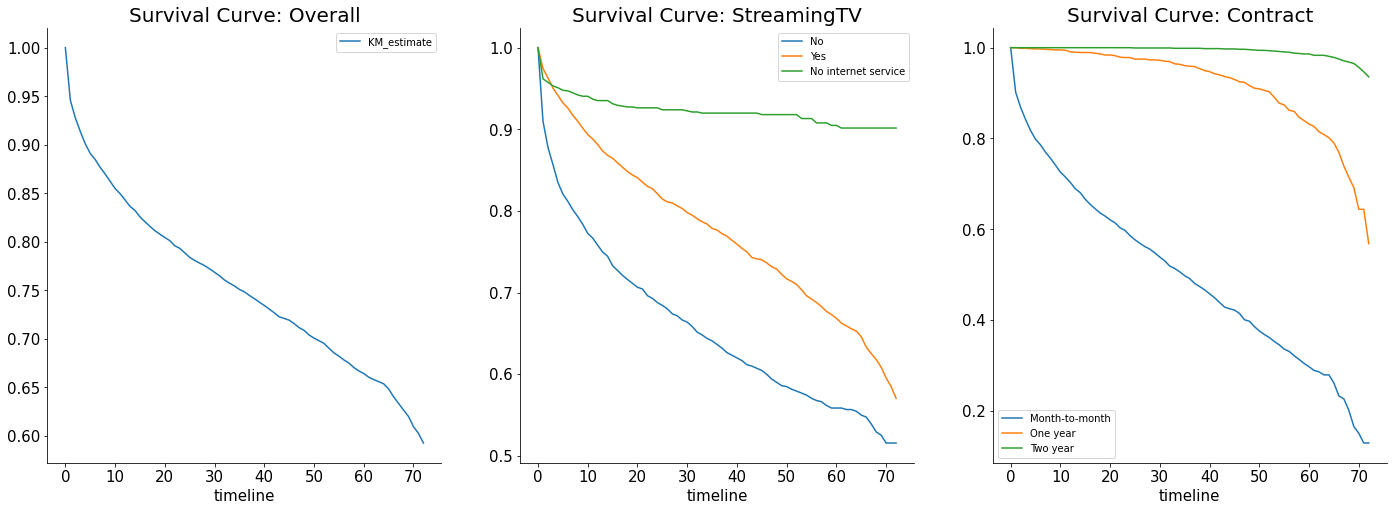

In [211]:
from lifelines import KaplanMeierFitter

# Creating Figure
figure, axis = plt.subplots(1,3,figsize = (24,8))

# Kaplan-Meier Estimate (Overall)
plot_axis = axis[0]
plot_config('Survival Curve: Overall', plot_axis,'','')
rods_survival_plot(main.time, main.event_occurred, plot_axis,label = None)

# Survival Curve By Streaming TV
plot_axis = axis[1]
plot_config('Survival Curve: StreamingTV', plot_axis,'','')
label = 'StreamingTV'
for value in main[label].unique():
    label_data = main[main[label] == value]
    rods_survival_plot(label_data.time, label_data.event_occurred, plot_axis,label = value)


# Type Of Contract
plot_axis = axis[2]
plot_config('Survival Curve: Contract', plot_axis,'','')
label = 'Contract'
for value in main[label].unique():
    label_data = main[main[label] == value]
    rods_survival_plot(label_data.time, label_data.event_occurred, plot_axis,label = value)


### Hazard Function - Cox Proportional Hazard Model Summary

In [212]:
from lifelines import CoxPHFitter

main['Partner'] = main['Partner'].map({'No':0, 'Yes':1})
main['Dependents'] = main['Dependents'].map({'No':0, 'Yes':1})
main['PhoneService'] = main['PhoneService'].map({'No':0, 'Yes':1})

# Initialize and fit the model
preliminary_cols = ['MonthlyCharges','SeniorCitizen','PhoneService','time','event_occurred']
coxph = CoxPHFitter()
coxph.fit(main[preliminary_cols], duration_col='time', event_col='event_occurred')

# Print model summary
coxph.print_summary()

"""
Notes:
Looking at p we can learn 'Age_in_years' and 'Months_from_Diagnosis' are not significant. (since p_value !< .05)
We can also see this with the factor effects plot below.""";

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'time'
                event col = 'event_occurred'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15586.08
         time fit was run = 2022-04-21 17:11:38 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
MonthlyCharges   0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
SeniorCitizen    0.47       1.59       0.05             0.36             0.57                 1.43                 1.77
PhoneService    -0.10       0.90       0.08            -0.27             0.06                 0.76                 1.06

                 cmp to     z      p   -log2(p)
covariate                                      
MonthlyCharges     0.00  5.99 <0.005      28.80
SeniorCitizen      0.00  8.55 <0.005      56.18
PhoneService       0.00 -1.24   0.21       2.22
---
Concordance = 0.54
Partial AIC = 31178.16
log-likelihood ratio test = 133.92 on 3 df
-log2(p) of ll-ratio test = 93.38

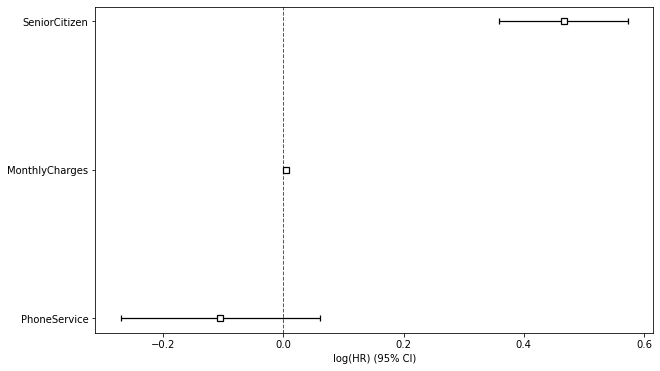

Solving environment: ...working... done

# All requested packages already installed.



In [213]:
# Plot factor effects 
figure, axis = plt.subplots(1,figsize = (10,6))
coxph.plot();

### Hazard Function - Cox Proportional Hazard Model Prediction

In [214]:
# Current patients still alive
test_sample = main.loc[main['event_occurred'] == False]

"""
Notes:
Predicted survival probability of patient 1 after 999 more days is 0.5597% however it is 08.92% for patient 63
Like other regression models, also Cox-PH model makes initial assumptions about data. To check if assumptions hold, we can use check_assumptions.
"""

# Predict survival probabilities 
coxph.predict_survival_function(test_sample,conditional_after=test_sample['time'])

,0,1,3,6,7,9,10,11,12,14,...,7030,7031,7033,7035,7036,7037,7038,7039,7040,7042
0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.000000,1.000000
1.0,0.984445,0.996081,0.995881,0.996854,0.995076,0.997462,0.995951,0.996048,0.994788,0.995802,...,0.989414,0.992564,0.995758,0.996081,0.992656,1.0,0.994321,1.0,0.993859,0.989076
2.0,0.972291,0.993404,0.990952,0.991200,0.988961,0.994785,0.989644,0.992345,0.990745,0.992102,...,0.979871,0.986369,0.991764,0.992331,0.987945,1.0,0.990564,1.0,0.987623,0.978245
3.0,0.961354,0.989338,0.987707,0.985447,0.982751,0.988361,0.984800,0.989362,0.985085,0.988632,...,0.972369,0.977573,0.987383,0.986315,0.980612,1.0,0.987251,1.0,0.983619,0.967493
4.0,0.952768,0.985754,0.982180,0.981641,0.978764,0.978435,0.980244,0.986500,0.981371,0.984243,...,0.967603,0.970963,0.982913,0.983372,0.974986,1.0,0.984142,1.0,0.977382,0.950884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68.0,0.715358,0.823427,0.852152,0.755512,0.750208,0.920381,0.763785,0.804876,0.884533,0.749147,...,0.752200,0.833614,0.825476,0.756019,0.723725,1.0,0.766712,1.0,0.754082,0.924332
69.0,0.706066,0.823427,0.852152,0.755512,0.750208,0.920381,0.763785,0.804876,0.884533,0.749147,...,0.746616,0.833614,0.825476,0.756019,0.723725,1.0,0.766712,1.0,0.754082,0.924332
70.0,0.699952,0.823427,0.852152,0.755512,0.750208,0.920381,0.763785,0.804876,0.884533,0.749147,...,0.738544,0.833614,0.825476,0.756019,0.723725,1.0,0.766712,1.0,0.754082,0.924332
71.0,0.691126,0.823427,0.852152,0.755512,0.750208,0.920381,0.763785,0.804876,0.884533,0.749147,...,0.738544,0.833614,0.825476,0.756019,0.723725,1.0,0.766712,1.0,0.754082,0.924332


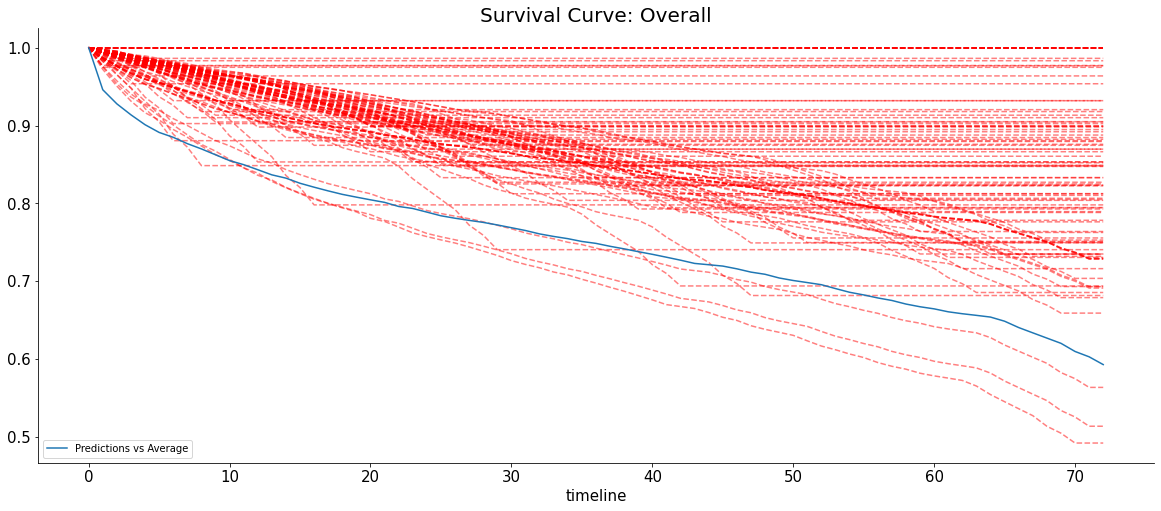

In [215]:
import matplotlib.patches as mpatches

figure, axis = plt.subplots(1,figsize = (20,8))

plot_axis = axis
plot_config('Predidction View', axis,'','')

predictions = coxph.predict_survival_function(test_sample,conditional_after=test_sample['time']).transpose()

for i in range(predictions[0:100].shape[0]): 
    plt.plot(predictions.iloc[i], color = 'red', alpha = 0.5, linestyle='--')

# Kaplan-Meier Estimate (Overall)]
plot_config('Survival Curve: Overall', plot_axis,'','')
rods_survival_plot(main.time, main.event_occurred, plot_axis, 'Predictions vs Average')